# Method 6 - Best Minus Rest Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Managers with Best Fresh Ideas

fresh_idea_mgrs = valid_data.merge(flat_qty).merge(flat_pos_size)
fresh_idea_mgrs = fresh_idea_mgrs[fresh_idea_mgrs['pos_rank'] == 1][['datadate', 'institution_id']].drop_duplicates()
fresh_idea_mgrs['fresh'] = 1

# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()
long_ideas = long_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')
                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()
short_ideas = short_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

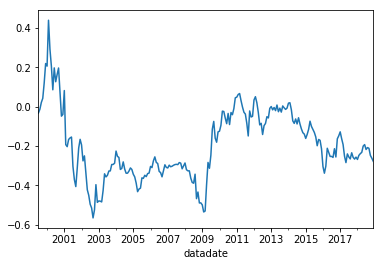

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.219110
2000-12-31   -0.211900
2001-12-31   -0.131813
2002-12-31   -0.383724
2003-12-31    0.386693
2004-12-31   -0.044316
2005-12-31   -0.027371
2006-12-31    0.043816
2007-12-31    0.010242
2008-12-31   -0.267756
2009-12-31    0.704819
2010-12-31    0.198499
2011-12-31   -0.090176
2012-12-31    0.042519
2013-12-31    0.001252
2014-12-31   -0.132936
2015-12-31   -0.087353
2016-12-31    0.084749
2017-12-31   -0.127046
2018-12-31   -0.028420
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     85.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.74e-44
Time:                        14:18:37   Log-Likelihood:                 412.93
No. Observations:                 234   AIC:                            -815.9
Df Residuals:                     229   BIC:                            -798.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.612      0.541      -0.004       0.007
mktrf          0.3980      0.078      5.095      0.000       0.244       0.552
me             0.3560      0.091      3.918      0.000       0.177       0.535
ia            -0.1000      0.138     -0.724      0.470      -0.372       0.172
roe           -1.0495      0.118     -8.877      0.000      -1.282      -0.817
==============================================================================
Omnibus:                       53.479   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.758
Skew:                           0.763   Prob(JB):                     2.17e-60
Kurtosis:                       8.085   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     88.90
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-45
Time:                        14:18:37   Log-Likelihood:                 412.93
No. Observations:                 234   AIC:                            -815.9
Df Residuals:                     229   BIC:                            -798.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.681      0.496      -0.003       0.007
mktrf          0.3980      0.108      3.683      0.000       0.186       0.610
me             0.3560      0.102      3.503      0.000       0.157       0.555
ia            -0.1000      0.214     -0.468      0.640      -0.519       0.319
roe           -1.0495      0.220     -4.773      0.000      -1.480      -0.618
==============================================================================
Omnibus:                       53.479   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.758
Skew:                           0.763   Prob(JB):                     2.17e-60
Kurtosis:                       8.085   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     98.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.74e-48
Time:                        14:18:37   Log-Likelihood:                 412.93
No. Observations:                 234   AIC:                            -815.9
Df Residuals:                     229   BIC:                            -798.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.634      0.526      -0.004       0.007
mktrf          0.3980      0.114      3.493      0.000       0.175       0.621
me             0.3560      0.113      3.158      0.002       0.135       0.577
ia            -0.1000      0.203     -0.492      0.623      -0.498       0.298
roe           -1.0495      0.235     -4.474      0.000      -1.509      -0.590
==============================================================================
Omnibus:                       53.479   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              274.758
Skew:                           0.763   Prob(JB):                     2.17e-60
Kurtosis:                       8.085   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     65.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.57e-42
Time:                        14:18:37   Log-Likelihood:                 410.12
No. Observations:                 234   AIC:                            -808.2
Df Residuals:                     228   BIC:                            -787.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.604      0.547      -0.004       0.008
mktrf          0.4682      0.079      5.897      0.000       0.312       0.625
smb            0.3047      0.105      2.909      0.004       0.098       0.511
hml            0.1087      0.124      0.880      0.380      -0.135       0.352
rmw           -1.0891      0.140     -7.798      0.000      -1.364      -0.814
cma            0.0290      0.178      0.164      0.870      -0.321       0.379
==============================================================================
Omnibus:                       79.887   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.184
Skew:                           1.298   Prob(JB):                     1.01e-78
Kurtosis:                       8.486   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     29.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.40e-23
Time:                        14:18:37   Log-Likelihood:                 410.12
No. Observations:                 234   AIC:                            -808.2
Df Residuals:                     228   BIC:                            -787.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.666      0.506      -0.003       0.007
mktrf          0.4682      0.084      5.563      0.000       0.303       0.633
smb            0.3047      0.107      2.848      0.004       0.095       0.514
hml            0.1087      0.212      0.514      0.607      -0.306       0.523
rmw           -1.0891      0.201     -5.416      0.000      -1.483      -0.695
cma            0.0290      0.298      0.098      0.922      -0.554       0.612
==============================================================================
Omnibus:                       79.887   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.184
Skew:                           1.298   Prob(JB):                     1.01e-78
Kurtosis:                       8.486   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     31.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.50e-24
Time:                        14:18:37   Log-Likelihood:                 410.12
No. Observations:                 234   AIC:                            -808.2
Df Residuals:                     228   BIC:                            -787.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.604      0.546      -0.004       0.008
mktrf          0.4682      0.078      5.978      0.000       0.315       0.622
smb            0.3047      0.112      2.709      0.007       0.084       0.525
hml            0.1087      0.164      0.662      0.508      -0.213       0.430
rmw           -1.0891      0.209     -5.207      0.000      -1.499      -0.679
cma            0.0290      0.269      0.108      0.914      -0.499       0.557
==============================================================================
Omnibus:                       79.887   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.184
Skew:                           1.298   Prob(JB):                     1.01e-78
Kurtosis:                       8.486   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     80.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.29e-42
Time:                        14:18:37   Log-Likelihood:                 409.29
No. Observations:                 234   AIC:                            -808.6
Df Residuals:                     229   BIC:                            -791.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.462      0.645      -0.007       0.004
mktrf          0.5278      0.073      7.225      0.000       0.384       0.672
smb            0.8382      0.091      9.192      0.000       0.658       1.018
hml           -0.2162      0.091     -2.386      0.018      -0.395      -0.038
umd           -0.4397      0.059     -7.397      0.000      -0.557      -0.323
==============================================================================
Omnibus:                       54.447   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.561
Skew:                           0.971   Prob(JB):                     1.12e-36
Kurtosis:                       6.635   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     59.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.75e-34
Time:                        14:18:37   Log-Likelihood:                 409.29
No. Observations:                 234   AIC:                            -808.6
Df Residuals:                     229   BIC:                            -791.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.595      0.552      -0.006       0.003
mktrf          0.5278      0.084      6.292      0.000       0.363       0.692
smb            0.8382      0.086      9.722      0.000       0.669       1.007
hml           -0.2162      0.140     -1.547      0.122      -0.490       0.058
umd           -0.4397      0.105     -4.193      0.000      -0.645      -0.234
==============================================================================
Omnibus:                       54.447   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.561
Skew:                           0.971   Prob(JB):                     1.12e-36
Kurtosis:                       6.635   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     75.66
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.66e-41
Time:                        14:18:37   Log-Likelihood:                 409.29
No. Observations:                 234   AIC:                            -808.6
Df Residuals:                     229   BIC:                            -791.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.594      0.553      -0.006       0.003
mktrf          0.5278      0.088      5.989      0.000       0.355       0.701
smb            0.8382      0.079     10.576      0.000       0.683       0.994
hml           -0.2162      0.135     -1.598      0.110      -0.481       0.049
umd           -0.4397      0.107     -4.127      0.000      -0.648      -0.231
==============================================================================
Omnibus:                       54.447   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.561
Skew:                           0.971   Prob(JB):                     1.12e-36
Kurtosis:                       6.635   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     42.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.24e-22
Time:                        14:18:37   Log-Likelihood:                 189.24
No. Observations:                 120   AIC:                            -368.5
Df Residuals:                     115   BIC:                            -354.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.005      1.049      0.296      -0.005       0.015
mktrf          0.3744      0.132      2.844      0.005       0.114       0.635
me             0.2597      0.130      1.998      0.048       0.002       0.517
ia            -0.2457      0.204     -1.207      0.230      -0.649       0.158
roe           -1.0456      0.180     -5.803      0.000      -1.403      -0.689
==============================================================================
Omnibus:                       18.700   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.896
Skew:                           0.516   Prob(JB):                     2.41e-11
Kurtosis:                       5.952   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     89.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-34
Time:                        14:18:37   Log-Likelihood:                 189.24
No. Observations:                 120   AIC:                            -368.5
Df Residuals:                     115   BIC:                            -354.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.310      0.190      -0.003       0.013
mktrf          0.3744      0.157      2.388      0.017       0.067       0.682
me             0.2597      0.137      1.890      0.059      -0.010       0.529
ia            -0.2457      0.296     -0.830      0.407      -0.826       0.335
roe           -1.0456      0.295     -3.543      0.000      -1.624      -0.467
==============================================================================
Omnibus:                       18.700   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.896
Skew:                           0.516   Prob(JB):                     2.41e-11
Kurtosis:                       5.952   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     109.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.62e-38
Time:                        14:18:37   Log-Likelihood:                 189.24
No. Observations:                 120   AIC:                            -368.5
Df Residuals:                     115   BIC:                            -354.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.004      1.312      0.189      -0.003       0.013
mktrf          0.3744      0.167      2.244      0.025       0.047       0.701
me             0.2597      0.151      1.719      0.086      -0.036       0.556
ia            -0.2457      0.278     -0.885      0.376      -0.790       0.298
roe           -1.0456      0.325     -3.215      0.001      -1.683      -0.408
==============================================================================
Omnibus:                       18.700   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.896
Skew:                           0.516   Prob(JB):                     2.41e-11
Kurtosis:                       5.952   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     33.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.85e-21
Time:                        14:18:37   Log-Likelihood:                 188.93
No. Observations:                 120   AIC:                            -365.9
Df Residuals:                     114   BIC:                            -349.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.005      1.211      0.228      -0.004       0.016
mktrf          0.5539      0.140      3.963      0.000       0.277       0.831
smb            0.2260      0.158      1.428      0.156      -0.088       0.540
hml           -0.1472      0.194     -0.759      0.449      -0.531       0.237
rmw           -0.9035      0.229     -3.950      0.000      -1.357      -0.450
cma            0.0757      0.251      0.302      0.763      -0.421       0.572
==============================================================================
Omnibus:                       44.051   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.673
Skew:                           1.368   Prob(JB):                     2.30e-27
Kurtosis:                       7.129   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     20.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.76e-14
Time:                        14:18:37   Log-Likelihood:                 188.93
No. Observations:                 120   AIC:                            -365.9
Df Residuals:                     114   BIC:                            -349.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.004      1.662      0.096      -0.001       0.013
mktrf          0.5539      0.154      3.593      0.000       0.252       0.856
smb            0.2260      0.144      1.565      0.118      -0.057       0.509
hml           -0.1472      0.186     -0.790      0.429      -0.512       0.218
rmw           -0.9035      0.262     -3.452      0.001      -1.416      -0.391
cma            0.0757      0.351      0.215      0.829      -0.613       0.764
==============================================================================
Omnibus:                       44.051   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.673
Skew:                           1.368   Prob(JB):                     2.30e-27
Kurtosis:                       7.129   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     20.54
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.40e-14
Time:                        14:18:37   Log-Likelihood:                 188.93
No. Observations:                 120   AIC:                            -365.9
Df Residuals:                     114   BIC:                            -349.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.004      1.627      0.104      -0.001       0.013
mktrf          0.5539      0.135      4.088      0.000       0.288       0.819
smb            0.2260      0.146      1.547      0.122      -0.060       0.512
hml           -0.1472      0.140     -1.050      0.294      -0.422       0.128
rmw           -0.9035      0.284     -3.176      0.001      -1.461      -0.346
cma            0.0757      0.312      0.243      0.808      -0.535       0.686
==============================================================================
Omnibus:                       44.051   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.673
Skew:                           1.368   Prob(JB):                     2.30e-27
Kurtosis:                       7.129   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     49.29
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.33e-24
Time:                        14:18:37   Log-Likelihood:                 194.48
No. Observations:                 120   AIC:                            -379.0
Df Residuals:                     115   BIC:                            -365.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.005      0.489      0.626      -0.007       0.011
mktrf          0.5671      0.111      5.109      0.000       0.347       0.787
smb            0.7467      0.126      5.909      0.000       0.496       0.997
hml           -0.4458      0.127     -3.522      0.001      -0.697      -0.195
umd           -0.4175      0.078     -5.349      0.000      -0.572      -0.263
==============================================================================
Omnibus:                       29.138   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.434
Skew:                           1.023   Prob(JB):                     5.57e-13
Kurtosis:                       5.665   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     53.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-25
Time:                        14:18:37   Log-Likelihood:                 194.48
No. Observations:                 120   AIC:                            -379.0
Df Residuals:                     115   BIC:                            -365.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.799      0.424      -0.003       0.008
mktrf          0.5671      0.114      4.981      0.000       0.344       0.790
smb            0.7467      0.096      7.797      0.000       0.559       0.934
hml           -0.4458      0.146     -3.050      0.002      -0.732      -0.159
umd           -0.4175      0.113     -3.694      0.000      -0.639      -0.196
==============================================================================
Omnibus:                       29.138   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.434
Skew:                           1.023   Prob(JB):                     5.57e-13
Kurtosis:                       5.665   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     75.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.82e-31
Time:                        14:18:37   Log-Likelihood:                 194.48
No. Observations:                 120   AIC:                            -379.0
Df Residuals:                     115   BIC:                            -365.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      0.908      0.364      -0.003       0.007
mktrf          0.5671      0.118      4.795      0.000       0.335       0.799
smb            0.7467      0.084      8.900      0.000       0.582       0.911
hml           -0.4458      0.132     -3.379      0.001      -0.704      -0.187
umd           -0.4175      0.117     -3.576      0.000      -0.646      -0.189
==============================================================================
Omnibus:                       29.138   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.434
Skew:                           1.023   Prob(JB):                     5.57e-13
Kurtosis:                       5.665   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     47.50
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.65e-23
Time:                        14:18:37   Log-Likelihood:                 244.17
No. Observations:                 114   AIC:                            -478.3
Df Residuals:                     109   BIC:                            -464.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.003     -0.237      0.813      -0.006       0.005
mktrf          0.3734      0.085      4.371      0.000       0.204       0.543
me             0.5929      0.132      4.495      0.000       0.331       0.854
ia             0.1752      0.183      0.957      0.341      -0.187       0.538
roe           -1.0524      0.161     -6.546      0.000      -1.371      -0.734
==============================================================================
Omnibus:                       31.660   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.698
Skew:                           1.082   Prob(JB):                     4.45e-16
Kurtosis:                       6.194   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     41.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.92e-21
Time:                        14:18:37   Log-Likelihood:                 244.17
No. Observations:                 114   AIC:                            -478.3
Df Residuals:                     109   BIC:                            -464.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.298      0.766      -0.005       0.004
mktrf          0.3734      0.110      3.381      0.001       0.157       0.590
me             0.5929      0.168      3.525      0.000       0.263       0.923
ia             0.1752      0.209      0.839      0.402      -0.234       0.584
roe           -1.0524      0.216     -4.881      0.000      -1.475      -0.630
==============================================================================
Omnibus:                       31.660   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.698
Skew:                           1.082   Prob(JB):                     4.45e-16
Kurtosis:                       6.194   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     50.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.06e-24
Time:                        14:18:37   Log-Likelihood:                 244.17
No. Observations:                 114   AIC:                            -478.3
Df Residuals:                     109   BIC:                            -464.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.288      0.773      -0.005       0.004
mktrf          0.3734      0.112      3.337      0.001       0.154       0.593
me             0.5929      0.195      3.045      0.002       0.211       0.975
ia             0.1752      0.218      0.804      0.421      -0.252       0.602
roe           -1.0524      0.216     -4.881      0.000      -1.475      -0.630
==============================================================================
Omnibus:                       31.660   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.698
Skew:                           1.082   Prob(JB):                     4.45e-16
Kurtosis:                       6.194   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     40.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.19e-23
Time:                        14:18:37   Log-Likelihood:                 246.72
No. Observations:                 114   AIC:                            -481.4
Df Residuals:                     108   BIC:                            -465.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.003     -0.496      0.621      -0.007       0.004
mktrf          0.3973      0.080      4.963      0.000       0.239       0.556
smb            0.4878      0.130      3.754      0.000       0.230       0.745
hml            0.4439      0.166      2.678      0.009       0.115       0.772
rmw           -1.1478      0.203     -5.656      0.000      -1.550      -0.746
cma            0.0132      0.258      0.051      0.959      -0.498       0.524
==============================================================================
Omnibus:                        4.844   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.239
Skew:                           0.436   Prob(JB):                        0.120
Kurtosis:                       3.364   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     24.30
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-16
Time:                        14:18:38   Log-Likelihood:                 246.72
No. Observations:                 114   AIC:                            -481.4
Df Residuals:                     108   BIC:                            -465.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.003     -0.483      0.629      -0.007       0.004
mktrf          0.3973      0.080      4.988      0.000       0.241       0.553
smb            0.4878      0.131      3.725      0.000       0.231       0.745
hml            0.4439      0.195      2.280      0.023       0.062       0.826
rmw           -1.1478      0.200     -5.745      0.000      -1.539      -0.756
cma            0.0132      0.272      0.048      0.961      -0.521       0.547
==============================================================================
Omnibus:                        4.844   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.239
Skew:                           0.436   Prob(JB):                        0.120
Kurtosis:                       3.364   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     27.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.45e-18
Time:                        14:18:38   Log-Likelihood:                 246.72
No. Observations:                 114   AIC:                            -481.4
Df Residuals:                     108   BIC:                            -465.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.003     -0.443      0.658      -0.008       0.005
mktrf          0.3973      0.083      4.789      0.000       0.235       0.560
smb            0.4878      0.147      3.312      0.001       0.199       0.777
hml            0.4439      0.157      2.836      0.005       0.137       0.751
rmw           -1.1478      0.178     -6.453      0.000      -1.496      -0.799
cma            0.0132      0.277      0.048      0.962      -0.529       0.555
==============================================================================
Omnibus:                        4.844   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.239
Skew:                           0.436   Prob(JB):                        0.120
Kurtosis:                       3.364   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     38.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.49e-20
Time:                        14:18:38   Log-Likelihood:                 236.51
No. Observations:                 114   AIC:                            -463.0
Df Residuals:                     109   BIC:                            -449.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.791      0.431      -0.009       0.004
mktrf          0.4382      0.087      5.061      0.000       0.267       0.610
smb            0.7541      0.135      5.585      0.000       0.486       1.022
hml            0.4620      0.139      3.323      0.001       0.186       0.738
umd           -0.3364      0.105     -3.207      0.002      -0.544      -0.128
==============================================================================
Omnibus:                        8.191   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                9.050
Skew:                           0.459   Prob(JB):                       0.0108
Kurtosis:                       4.031   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     33.64
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.91e-18
Time:                        14:18:38   Log-Likelihood:                 236.51
No. Observations:                 114   AIC:                            -463.0
Df Residuals:                     109   BIC:                            -449.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.887      0.375      -0.008       0.003
mktrf          0.4382      0.092      4.772      0.000       0.258       0.618
smb            0.7541      0.136      5.540      0.000       0.487       1.021
hml            0.4620      0.184      2.514      0.012       0.102       0.822
umd           -0.3364      0.110     -3.060      0.002      -0.552      -0.121
==============================================================================
Omnibus:                        8.191   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                9.050
Skew:                           0.459   Prob(JB):                       0.0108
Kurtosis:                       4.031   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     39.88
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-20
Time:                        14:18:38   Log-Likelihood:                 236.51
No. Observations:                 114   AIC:                            -463.0
Df Residuals:                     109   BIC:                            -449.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.846      0.397      -0.008       0.003
mktrf          0.4382      0.096      4.568      0.000       0.250       0.626
smb            0.7541      0.132      5.712      0.000       0.495       1.013
hml            0.4620      0.167      2.761      0.006       0.134       0.790
umd           -0.3364      0.115     -2.927      0.003      -0.562      -0.111
==============================================================================
Omnibus:                        8.191   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                9.050
Skew:                           0.459   Prob(JB):                       0.0108
Kurtosis:                       4.031   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""